In [1]:
from tqdm import tqdm

#--scipy stack
import numpy as np

#--torch
import torch

#--matplotlib
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec


### Import physical params

In [2]:
import params as par 
print(f"par.M: {par.M}")

par.M: 0.93891897


### PDF (import and instantiate)

In [3]:
from pdf import PDF
pdf = PDF()

### Inspect/Visualize the PDF
  - Discretize the x/Q^2 domain
  - Visualize the PDF for two parameter instances everywhere in the domain

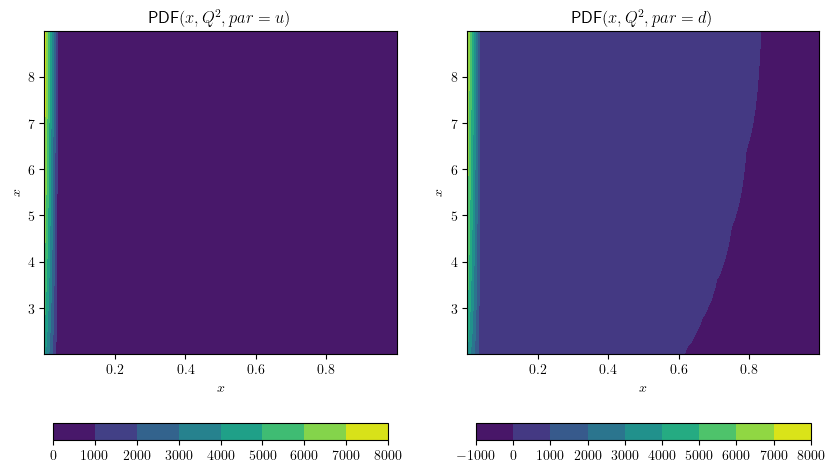

In [4]:
# Settings
offset     = 1e-4    # offset in the domain away from bounds; 0 is not attainable
num_points = 25      # number of discretization points
x_bounds   = (0, 1)  # bounds of x
Q2_bounds  = (2, 9)  # bounds of Q^2  # NOTE: Q^2 can't be below 1, but it can grow up (this requies more experimental & $ cost)

# Note: Better to look at PDF in log-space
# Create the 2D grid
X, Q2 = torch.meshgrid(
    torch.linspace(x_bounds[0] + offset, x_bounds[1]-offset, num_points) ,
    torch.linspace(Q2_bounds[0] + offset, Q2_bounds[1]-offset, num_points) ,
    indexing='xy',
)

# Evaluate PDF for given par_u parameter in the whole domain
pdf_u_values = pdf.get_u(X, Q2)
# pdf_u_values = pdf.get_pdf(X, Q2, par=pdf.par_u)  # NOTE: this does the same as above!

# Evaluate PDF for given par_d parameter in the whole domain
pdf_d_values = pdf.get_d(X, Q2)
# pdf_d_values = pdf.get_pdf(X, Q2, par=pdf.par_d)  # NOTE: this does the same as above!

# Plot PDF for both par_u and par_d parameters
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
surf_1 = axes[0].contourf(X.detach().numpy(), Q2.detach().numpy(), pdf_u_values.detach().numpy())
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$x$")
axes[0].set_title(r"PDF$(x, Q^2, par=u)$")
# add colorbar
fig.colorbar(surf_1, shrink=0.95, aspect=20, location='bottom')

surf_2 = axes[1].contourf(X.detach().numpy(), Q2.detach().numpy(), pdf_d_values.detach().numpy())
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$x$")
axes[1].set_title(r"PDF$(x, Q^2, par=d)$")
# add colorbar
fig.colorbar(surf_2, shrink=0.95, aspect=20, location='bottom')

### Test PDF differentiability 
  - This tests the PDF derivate with respect to physics parameters at two instances `par_u` and `par_d`; (two parameter instances inside PDF class)
  - The objective is defined as `PDF(x, Q^2, par_u) + pdf(x, Q^2, par_d)` and is evaluated at all events `(x, Q^2)` in the discretized domain

**Question**: This is just derivative of the PDF with respect to physics parameters, right?

In [5]:
# Define an objective as the sum of PDF values for par_u and par_d
x = torch.tensor([0.1])
Q2 = torch.tensor([5.])
x, Q2 = torch.meshgrid(x, Q2)

test = torch.sum(
    pdf.get_u(x,Q2) + pdf.get_d(x,Q2)
)

# Propagate the test_objective backward (to get derivative w.r.t parameters par_u and par_d)
test.backward()

# Print derivatives:
print(f"Derivative of PDF w.r.t par_u:\n{pdf.par_u.grad}\n")
print(f"Derivative of PDF w.r.t par_d:\n{pdf.par_d.grad}\n")

Derivative of PDF w.r.t par_u:
tensor([ 3.8194e+01,  3.8727e+01,  3.9267e+01, -1.5639e+01, -1.5857e+01,
        -1.6078e+01, -7.1561e-01, -7.2559e-01, -7.3571e-01,  2.0379e-01,
         2.0663e-01,  2.0951e-01,  2.0379e-02,  2.0663e-02,  2.0951e-02,
         2.0379e-03,  2.0663e-03,  2.0951e-03])

Derivative of PDF w.r.t par_d:
tensor([ 2.4141e+01,  2.4478e+01,  2.4819e+01, -1.0379e+01, -1.0524e+01,
        -1.0671e+01, -4.7494e-01, -4.8156e-01, -4.8828e-01,  1.7384e-01,
         1.7627e-01,  1.7873e-01,  1.7384e-02,  1.7627e-02,  1.7873e-02,
         1.7384e-03,  1.7627e-03,  1.7873e-03])



/Users/attia/AHMED_HOME/Research/Projects/DA/QuantOm_HMC/Code/approximate_sampling_gradients/theory/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


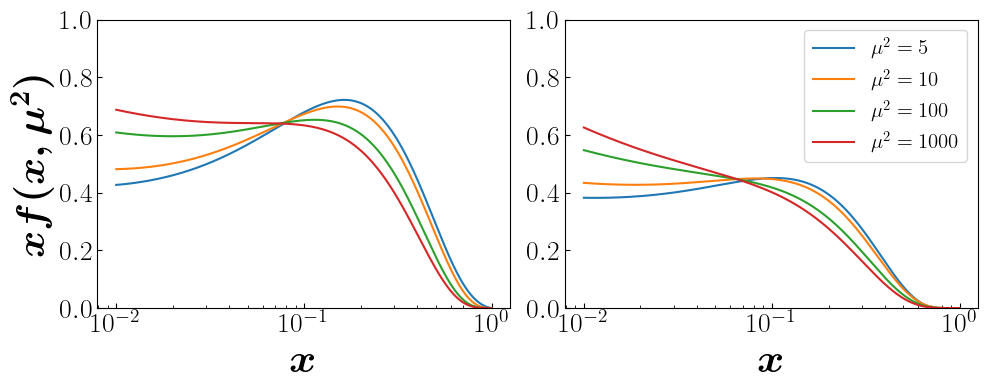

In [6]:
## NOTE: Here, mu^2 is Q^2, and y-axis in plots show cross-section for selected realizations of $Q^2$ over a grid of x (log-scale)

nrows, ncols = 1, 2
AX = []
fig = py.figure(figsize=(ncols*5,nrows*4))

# Another instance of the PDF
pdf = PDF()

x = 10**torch.linspace(-2, np.log10(0.99), 1000)
Q2 = torch.tensor([5.0, 10.0, 100.0, 1000.0])
Q2, x = torch.meshgrid(Q2 , x)

ax = py.subplot(nrows,ncols,1)
AX.append(ax)
xu = (x*pdf.get_u(x,Q2)).detach()
for i in range(xu.shape[0]):
    ax.plot(x[i].numpy(),xu[i].numpy(),label=r'$\mu^2=%d$'%Q2.numpy()[i,0])

ax = py.subplot(nrows,ncols,2)
AX.append(ax)
xd = (x*pdf.get_d(x,Q2)).detach()
for i in range(xd.shape[0]):
    ax.plot(x[i].numpy(),xd[i].numpy(),label=r'$\mu^2=%d$'%Q2.numpy()[i,0])

for ax in AX:
    ax.semilogx()
    ax.set_ylim(0,1)
    ax.tick_params(axis='both', which='both', labelsize=20,direction='in')
    ax.set_xlabel(r'\boldmath{$x$}',size=30)
AX[0].set_ylabel(r'\boldmath{$xf(x,\mu^2)$}',size=30)
AX[1].legend(fontsize=15,loc=1)
py.tight_layout()

# IDIS class

In [7]:
from idis import IDIS

In [8]:
idis = IDIS()
x = torch.tensor([0.1])
Q2 = torch.tensor([5.])
x, Q2 = torch.meshgrid(x, Q2)

rs = 140
tar = 'p'
xsec = idis.get_diff_xsec(x, Q2, rs, tar, option='xQ2')
xsec.backward()

print(idis.pdf.par_u.grad)
print(idis.pdf.par_d.grad)

tensor([ 4.5345e-04,  4.5978e-04,  4.6619e-04, -1.8567e-04, -1.8826e-04,
        -1.9089e-04, -8.4959e-06, -8.6145e-06, -8.7347e-06,  2.4195e-06,
         2.4532e-06,  2.4874e-06,  2.4195e-07,  2.4532e-07,  2.4874e-07,
         2.4195e-08,  2.4532e-08,  2.4874e-08])
tensor([ 7.1652e-05,  7.2652e-05,  7.3666e-05, -3.0807e-05, -3.1237e-05,
        -3.1673e-05, -1.4097e-06, -1.4293e-06, -1.4493e-06,  5.1598e-07,
         5.2318e-07,  5.3048e-07,  5.1598e-08,  5.2318e-08,  5.3048e-08,
         5.1598e-09,  5.2318e-09,  5.3048e-09])


# MCEG class

In [9]:
from mceg import MCEG

In [10]:
nx = 30 
nQ2 = 20
mceg = MCEG(
    rs = 140,
    tar = 'p',
    W2min = 10,
    nx = nx,
    nQ2 = nQ2
) 

evts = mceg.gen_events(100, verb=False)

# test function (scalar) use to test differentiability   PDF(x, par_u)  par_u --> x
test = torch.sum(evts[0, 1])

# print(test, evts)
test.backward()

print(mceg.idis.pdf.par_u.grad)
print(mceg.idis.pdf.par_d.grad)


100%|██████████████████| 551/551 [00:00<00:00, 9329.33it/s]
/Users/attia/AHMED_HOME/Research/Projects/DA/QuantOm_HMC/Code/approximate_sampling_gradients/theory/DukeOwens/mceg.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(self.weights*N, dtype=int)
100%|█████████████████| 551/551 [00:00<00:00, 14566.03it/s]


tensor([-1.1999e-01,  1.2610e-01,  1.8041e-01,  3.1979e-02, -2.2014e-01,
        -2.5988e-01,  5.8439e-07, -4.0229e-06, -4.7492e-06, -5.5992e-07,
         4.0083e-06,  4.7250e-06, -8.9441e-11,  6.4028e-10,  7.5476e-10,
        -1.4287e-14,  1.0228e-13,  1.2057e-13])
tensor([-9.9252e-02,  3.1388e-03,  3.4374e-02, -3.1979e-02, -6.9202e-02,
        -6.8640e-02, -5.8439e-07, -1.2646e-06, -1.2544e-06,  5.8531e-07,
         1.2610e-06,  1.2500e-06,  9.3497e-11,  2.0144e-10,  1.9968e-10,
         1.4935e-14,  3.2178e-14,  3.1896e-14])


100%|█████████████████| 551/551 [00:00<00:00, 18442.31it/s]

tensor(0.0006, grad_fn=<SumBackward0>)


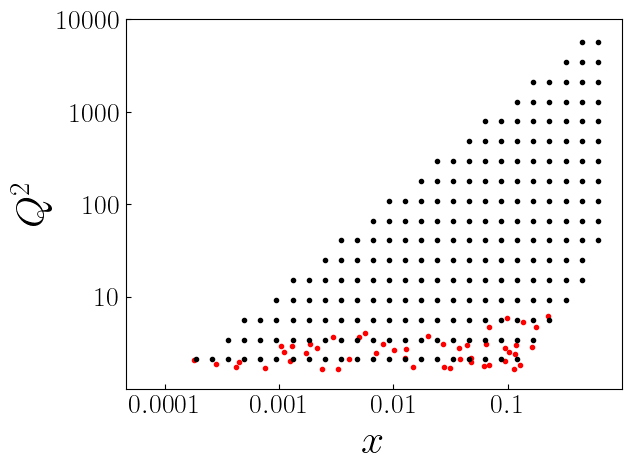

/Users/attia/AHMED_HOME/Research/Projects/DA/QuantOm_HMC/Code/approximate_sampling_gradients/theory/DukeOwens/mceg.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(self.weights*N, dtype=int)
100%|██████████████████| 551/551 [00:00<00:00, 8940.59it/s]

tensor(0.0006, grad_fn=<SumBackward0>)


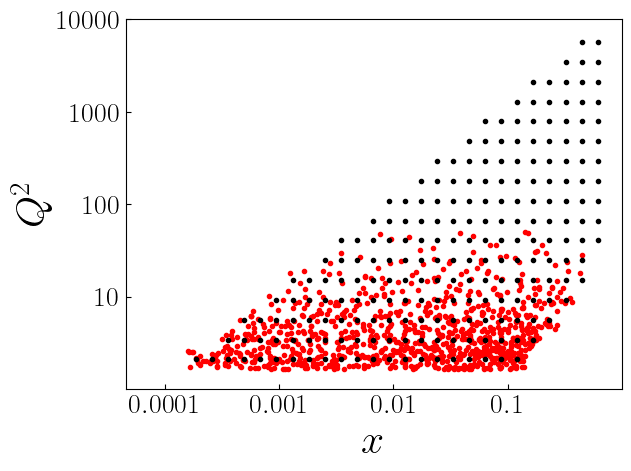

/Users/attia/AHMED_HOME/Research/Projects/DA/QuantOm_HMC/Code/approximate_sampling_gradients/theory/DukeOwens/mceg.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(self.weights*N, dtype=int)
100%|█████████████████| 551/551 [00:00<00:00, 16554.41it/s]


tensor(0.0006, grad_fn=<SumBackward0>)


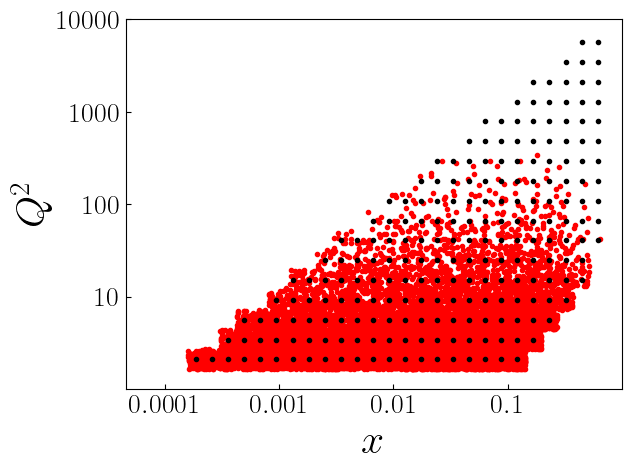

In [11]:
mceg.gen_events(100,verb=True);
mceg.gen_events(1000,verb=True);
mceg.gen_events(10000,verb=True);

In [12]:
nx=100; nQ2=300
mceg=MCEG(rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 
evts=mceg.gen_events(1000000,verb=False)

100%|██████████████| 29601/29601 [00:03<00:00, 8733.18it/s]
/Users/attia/AHMED_HOME/Research/Projects/DA/QuantOm_HMC/Code/approximate_sampling_gradients/theory/DukeOwens/mceg.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(self.weights*N, dtype=int)
100%|█████████████| 29601/29601 [00:01<00:00, 15331.36it/s]


# Quality control V0

In [13]:
hist=np.histogram2d(np.log(evts[:,0].detach().numpy())
                   ,np.log(evts[:,1].detach().numpy()),bins=(50,50))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
for i,j in tqdm((a,b) for a in range(hist[1].shape[0]-1) 
                      for b in range(hist[2].shape[0]-1)):
    if hist[0][i,j]>0: 
        x=torch.tensor(np.exp(0.5*(hist[1][i]+hist[1][i+1])))
        Q2=torch.tensor(np.exp(0.5*(hist[2][j]+hist[2][j+1])))
        true[i,j]=idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2').detach().numpy()
        
        dx=np.exp(hist[1][i+1])-np.exp(hist[1][i])
        dQ2=np.exp(hist[2][j+1])-np.exp(hist[2][j])
        reco[i,j]=hist[0][i,j]/dx/dQ2

reco*=mceg.total_xsec.detach().numpy()/np.sum(hist[0])

2500it [00:00, 4187.63it/s]


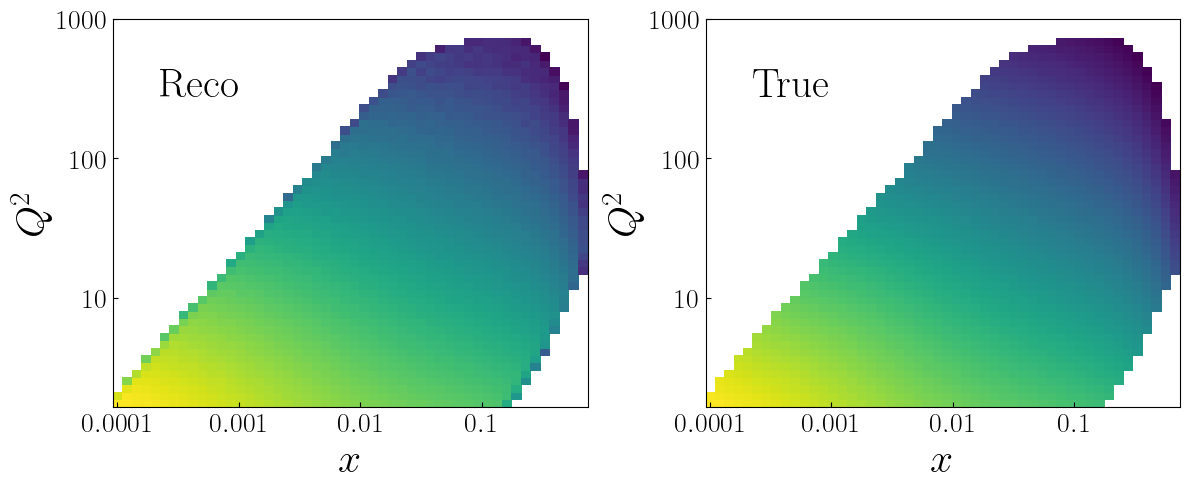

In [14]:
nrows,ncols=1,2; AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
ax=py.subplot(nrows,ncols,1);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],reco.T, norm=matplotlib.colors.LogNorm())
ax=py.subplot(nrows,ncols,2);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],true.T, norm=matplotlib.colors.LogNorm())
for ax in AX:
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_ylabel(r'$Q^2$',size=30)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
    ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
    ax.set_yticks(np.log([10,100,1000]))
    ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
AX[0].text(0.1,0.8,r'$\rm Reco$',transform=AX[0].transAxes,size=30)
AX[1].text(0.1,0.8,r'$\rm True$',transform=AX[1].transAxes,size=30)
py.tight_layout()

/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_45329/2653222341.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(hist[1][:-1],hist[2][:-1],reco.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_45329/2653222341.py:9: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(hist[1][:-1],hist[2][:-1],true.T,levels=levels,cmap=cmap,norm=colors.LogNorm())


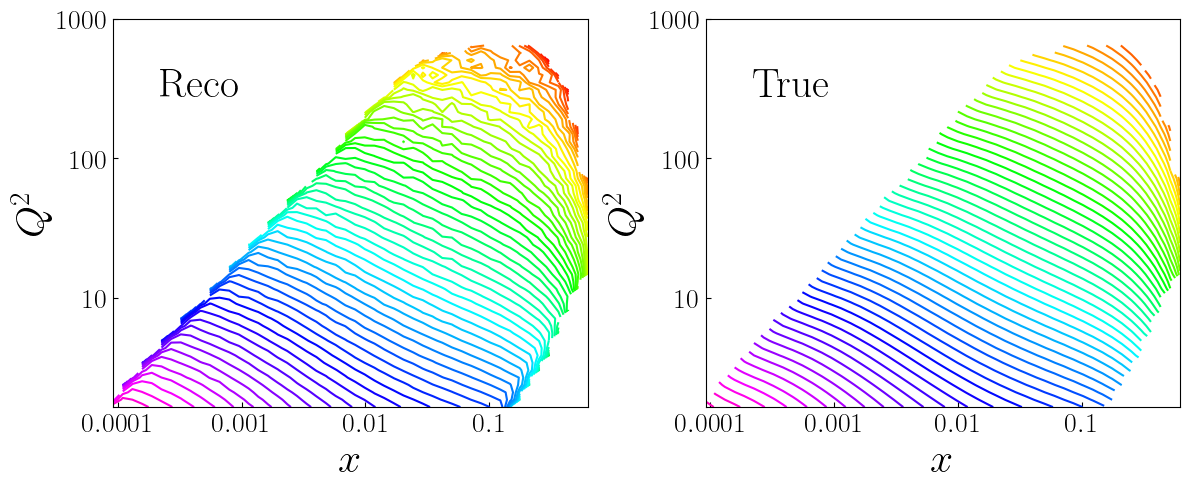

In [15]:
nrows,ncols=1,2; AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
cmap='gist_rainbow'

ax=py.subplot(nrows,ncols,1);AX.append(ax)
levels=10**np.linspace( np.log10(np.amin(reco[reco>0])),np.log10(np.amax(reco)),60)
cs = ax.contour(hist[1][:-1],hist[2][:-1],reco.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
ax=py.subplot(nrows,ncols,2);AX.append(ax)
cs = ax.contour(hist[1][:-1],hist[2][:-1],true.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
for ax in AX:
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_ylabel(r'$Q^2$',size=30)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
    ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
    ax.set_yticks(np.log([10,100,1000]))
    ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
AX[0].text(0.1,0.8,r'$\rm Reco$',transform=AX[0].transAxes,size=30)
AX[1].text(0.1,0.8,r'$\rm True$',transform=AX[1].transAxes,size=30)
py.tight_layout()

In [16]:
hist=np.histogram2d(np.log(evts[:,0].detach().numpy()),np.log(evts[:,1].detach().numpy()),bins=(nx,nQ2))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
stat=np.zeros(hist[0].shape)
entries=[(a,b) for a in range(hist[1].shape[0]-1) 
               for b in range(hist[2].shape[0]-1)]
for i,j in tqdm(entries):
    if hist[0][i,j]>0: 
        x=torch.tensor(np.exp(0.5*(hist[1][i]+hist[1][i+1])))
        Q2=torch.tensor(np.exp(0.5*(hist[2][j]+hist[2][j+1])))
        xmin =np.exp(hist[1][i]); xmax=np.exp(hist[1][i+1])
        Q2min=np.exp(hist[2][j]); Q2max=np.exp(hist[2][j+1])
        #dx=np.exp(hist[1][i+1])-np.exp(hist[1][i])
        #dQ2=np.exp(hist[2][j+1])-np.exp(hist[2][j])
        dx=xmax-xmin
        dQ2=Q2max-Q2min
        
        
        #itg_xQ2=np.vectorize(lambda x,Q2:idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2'))
        ##itg_x=lambda x: quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max)[0]
        ##true[i,j]=quad(itg_x,xmin,xmax)[0]/dx/dQ2
        #itg_x=np.vectorize(lambda x: fixed_quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max,n=10)[0])
        #true[i,j]=fixed_quad(itg_x,xmin,xmax,n=10)[0]/dx/dQ2
        
        true[i,j]=idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2').detach().numpy()
        
        reco[i,j]=hist[0][i,j]/dx/dQ2
        stat[i,j]=np.sqrt(hist[0][i,j])/dx/dQ2
        

reco*=mceg.total_xsec.detach().numpy()/np.sum(hist[0])
stat*=mceg.total_xsec.detach().numpy()/np.sum(hist[0])

100%|██████████████| 30000/30000 [00:06<00:00, 4371.35it/s]


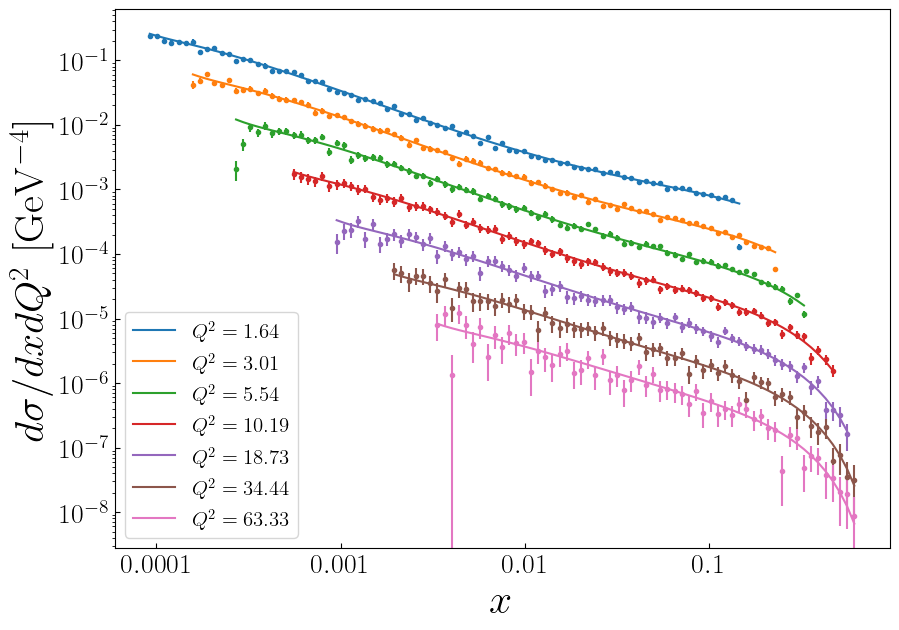

In [17]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*10,nrows*7))
ax=py.subplot(nrows,ncols,1)
nQ2_selects=10
dnQ2=int(hist[2].shape[0]/nQ2_selects)
for j in range(0,hist[2].shape[0]-1,dnQ2):
    if np.exp(hist[2][j])>100: continue
    cond=true[:,j]>0
    h,=ax.plot(hist[1][:-1][cond],true[:,j][cond],label=r'$Q^2=%0.2f$'%np.exp(hist[2][j]))
    cond=reco[:,j]>0
    #h,=ax.plot(hist[1][:-1][cond],reco[:,j][cond],'k:')
    ax.errorbar(hist[1][:-1][cond],reco[:,j][cond],stat[:,j][cond],fmt='.',color=h.get_color())
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_ylabel(r'$d\sigma/dxdQ^2~[{\rm GeV^{-4}}]$',size=30)
ax.set_xlabel(r'$x$',size=30)
ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
#ax.set_yticks(np.log([10,100,1000]))
#ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
ax.semilogy();
ax.legend(fontsize=15)